In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [824]:
df = pd.read_csv('data/concrete+compressive+strength/Concrete_Data.csv')
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Data Visualisation

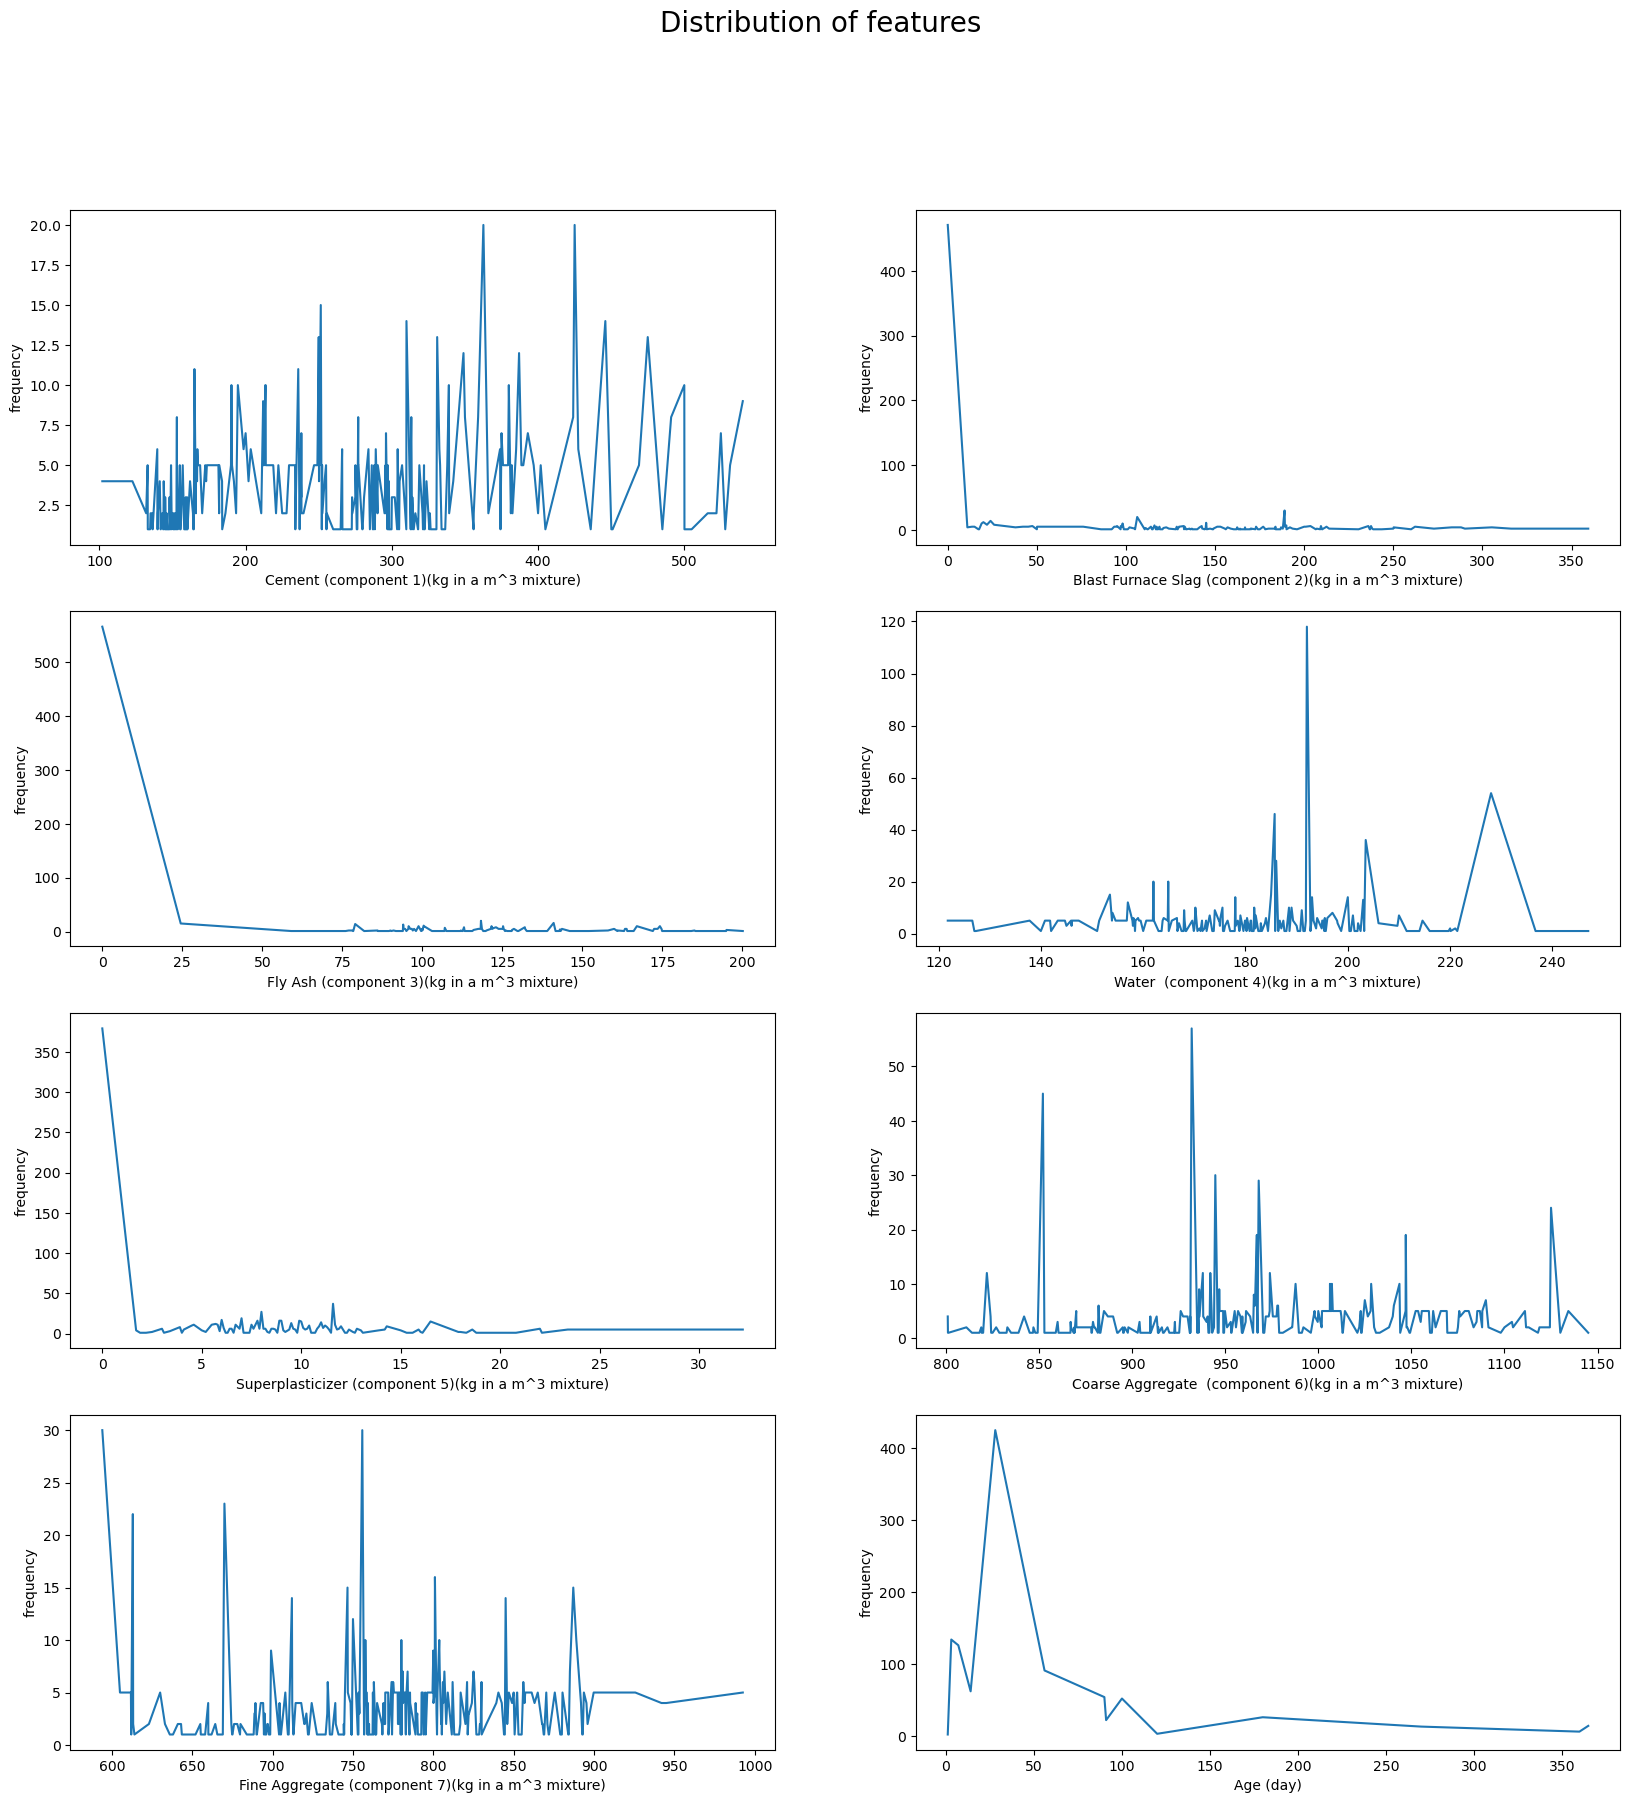

In [825]:
fig, axs = plt.subplots(4,2,figsize = (20,20))
fig.suptitle("Distribution of features",fontsize = 20)
col = 0
for ax in axs.flat:
    temp = df.iloc[:,col].value_counts().sort_index()
    ax.plot(temp.index,temp.values)
    ax.set_xlabel(df.columns[col])
    ax.set_ylabel("frequency")
    col+=1

In [826]:
from sklearn.model_selection import train_test_split
import enum

class activations(enum.Enum):
    tanh = 1
    Leaky_ReLU = 2
    
def tanh(z):
    return np.tanh(z)

def grad_tanh(z):
    return 1 - np.square(tanh(z))

def lrelu(z):
    return z if z >= 0 else 0.01*z

def grad_lrelu(z):
    return 1 if z >= 0 else 0.01

activations = [tanh, lrelu]
grad_activations = [grad_tanh, grad_lrelu]

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.3, random_state=42)


## BackProp

In [787]:
class NN_back:
    def __init__(self,hidden_units,activation):
        self.params = {
            'hidden_units': hidden_units,
            'activation': activation
        }
#         self.w_1 = np.array([[0.1 for col in range(8)] for row in range(hidden_units)])
#         self.w_2 = np.array([0.1 for col in range(hidden_units)])
        self.w_1 = np.random.randn(hidden_units,8)
        self.w_2 = np.random.randn(hidden_units)
        self.b_1 = np.random.randn(hidden_units)
        self.b_2 = np.random.randn(1)
        self.lr = 1e-03
        self.epochs = 1000
        self.convergence_factor = 1e-03

    def fit_batch(self,x_train,y_train, x_test, y_test):
        loss_list = []
        test_loss_list = []
        convergent_epoch = 1000
        for epoch in range(self.epochs):
            
#             forward pass ( Batch )
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_test)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_test)).mean()
            test_loss_list.append(loss)

            loss = 0
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_train)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_train)).mean()
            loss_list.append(loss)
            if(epoch > 0 and convergent_epoch == 1000 and np.abs(loss - loss_list[-2]) < self.convergence_factor):
                convergent_epoch = epoch+1
#             print(f"{epoch+1} == > {loss}")
            
#             backward pass

            grad_outputs_loss = np.vectorize(lambda output,d: (2*(output - d))/len(y_train))(outputs,y_train)
#             grad_w_2_loss = np.vectorize(lambda data: np.dot(grad_outputs_loss,data),signature = '(n)->()')(y_1.T)
            grad_w_2_loss = np.dot(y_1.T,grad_outputs_loss)
            w_2_,grad_outputs_loss_ = np.meshgrid(self.w_2,grad_outputs_loss)
            grad_y_1_loss = np.vectorize(lambda w,o: o*w)(w_2_,grad_outputs_loss_)
            grad_z_1_loss = np.vectorize(lambda cell,val: cell*grad_activations[self.params['activation']-1](val))(grad_y_1_loss,z_1)
            grad_w_1_loss = np.vectorize(lambda data: np.dot(x_train.T,data),signature = '(n)->(k)')(grad_z_1_loss.T)
            
#             print(grad_w_2_loss)
            self.b_2 -= self.lr*np.sum(grad_outputs_loss)
            self.w_2 -= self.lr*grad_w_2_loss
            self.b_1 -= self.lr*np.sum(grad_z_1_loss,axis=0)
            self.w_1 -= self.lr*grad_w_1_loss

        return loss_list, loss_list[-1], test_loss_list, convergent_epoch
        
    def predict(self,x_test,y_test):
        z_1 = np.vectorize(lambda data: np.dot(self.w_1,data) + self.b_1,signature = '(n)->(k)')(x_test)
        y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
        outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
        loss = np.square(np.subtract(outputs,y_test)).mean()
        return loss
        

## RProp

In [799]:
class NN_r:
    def __init__(self,hidden_units,activation):
        self.params = {
            'hidden_units': hidden_units,
            'activation': activation
        }
#         self.w_1 = np.array([[0.1 for col in range(8)] for row in range(hidden_units)])
#         self.w_2 = np.array([0.1 for col in range(hidden_units)])
        self.w_1 = np.random.randn(hidden_units,8)
        self.w_2 = np.random.randn(hidden_units)
        self.b_1 = np.random.randn(hidden_units)
        self.b_2 = np.random.randn(1)
        self.step = 1e-03
        self.step_min = 1e-06
        self.step_max = 1.0
        self.epochs = 1000
        self.alpha = 1.2
        self.beta = 0.5
        self.convergence_factor = 1e-03
    
    def sign(self,weight):
        return 1.0 if weight >=0 else -1.0
            
    def fit_batch(self,x_train,y_train,x_test,y_test):
        loss_list = []
        test_loss_list = []
        prev_grad_w_2_loss = np.zeros(self.w_2.shape)
        prev_grad_w_1_loss = np.zeros(self.w_1.shape)
        prev_grad_b_2_loss = np.zeros(self.b_2.shape)
        prev_grad_b_1_loss = np.zeros(self.b_1.shape)
        delta_1 = np.array([[self.step for col in range(self.w_1.shape[1])] for row in range(self.w_1.shape[0])])
        delta_2 = np.array([self.step for col in range(self.w_2.shape[0])])
        delta_b_1 = np.array([self.step for col in range(self.b_1.shape[0])])
        delta_b_2 = np.array(self.step)
        convergent_epoch = 1000
        for epoch in range(self.epochs):
            
#             forward pass ( Batch )
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_test)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_test)).mean()
            test_loss_list.append(loss)

            loss = 0
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_train)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_train)).mean()
            loss_list.append(loss)
            if(epoch > 0 and convergent_epoch == 1000 and np.abs(loss - loss_list[-2]) < self.convergence_factor):
                convergent_epoch = epoch+1
#             print(f"{epoch+1} == > {loss}")
            
#             backward pass

            grad_outputs_loss = np.vectorize(lambda output,d: (2*(output - d))/len(y_train))(outputs,y_train)
#             grad_w_2_loss = np.vectorize(lambda data: np.dot(grad_outputs_loss,data),signature = '(n)->()')(y_1.T)
            grad_w_2_loss = np.dot(y_1.T,grad_outputs_loss)
            w_2_,grad_outputs_loss_ = np.meshgrid(self.w_2,grad_outputs_loss)
            grad_y_1_loss = np.vectorize(lambda w,o: o*w)(w_2_,grad_outputs_loss_)
            grad_z_1_loss = np.vectorize(lambda cell,val: cell*grad_activations[self.params['activation']-1](val))(grad_y_1_loss,z_1)
            grad_w_1_loss = np.vectorize(lambda data: np.dot(x_train.T,data),signature = '(n)->(k)')(grad_z_1_loss.T)
            
            temp_weights_1 = []
            temp_weights_2 = []
            temp_bias_1 = []
            temp_bias_2 = []
            
            def upgrade_gradient(prev,curr):
                return curr if (self.sign(prev) == self.sign(curr)) else prev
                
            def upgrade_step(prev,curr,delta,layer):
                nonlocal temp_weights_1
                nonlocal temp_weights_2
                nonlocal temp_bias_1
                nonlocal temp_bias_2
                if self.sign(prev) == self.sign(curr):
                    if layer == 1:
                        temp_weights_1.append(0.0)
                    elif layer == 2:
                        temp_weights_2.append(0.0)
                    elif layer == 3:
                        temp_bias_1.append(0.0)
                    else:
                        temp_bias_2.append(0.0)
                        
                    return min(self.alpha*np.abs(delta),self.step_max)
                else:
                    if layer == 1:
                        temp_weights_1.append(delta)
                    elif layer == 2:
                        temp_weights_2.append(delta)
                    elif layer == 3:
                        temp_bias_1.append(delta)
                    else:
                        temp_bias_2.append(delta)
                    
                    return max(self.beta*np.abs(delta),self.step_min)
            
#             for the previous update
#             print(prev_grad_w_2_loss,grad_w_2_loss)
            if epoch > 0:
                delta_2 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta,2))(prev_grad_w_2_loss,grad_w_2_loss,delta_2)
                delta_1 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta,1))(prev_grad_w_1_loss,grad_w_1_loss,delta_1)
                delta_b_1 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta,3))(prev_grad_b_1_loss,np.sum(grad_z_1_loss,axis=0),delta_b_1)
                delta_b_2 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta,4))(prev_grad_b_2_loss,np.sum(grad_outputs_loss),delta_b_2)

                temp_weights_1 = np.array(temp_weights_1)[1:].reshape(self.w_1.shape)
                temp_weights_2 = np.array(temp_weights_2)[1:].reshape(self.w_2.shape)
                
                self.w_1 += temp_weights_1
                self.w_2 += temp_weights_2
                self.b_1 += temp_bias_1[1:]
                self.b_2 += temp_bias_2[1:]
                
                prev_grad_w_2_loss = np.vectorize(lambda prev,curr: upgrade_gradient(prev,curr))(prev_grad_w_2_loss,grad_w_2_loss)
                prev_grad_w_1_loss = np.vectorize(lambda prev,curr: upgrade_gradient(prev,curr))(prev_grad_w_1_loss,grad_w_1_loss)
                prev_grad_b_1_loss = np.vectorize(lambda prev,curr: upgrade_gradient(prev,curr))(prev_grad_b_1_loss,np.sum(grad_z_1_loss,axis=0))
                prev_grad_b_2_loss = np.vectorize(lambda prev,curr: upgrade_gradient(prev,curr))(prev_grad_b_2_loss,np.sum(grad_outputs_loss))
            else:
                prev_grad_w_2_loss = grad_w_2_loss
                prev_grad_w_1_loss = grad_w_1_loss
                prev_grad_b_1_loss = np.sum(grad_z_1_loss,axis=0)
                prev_grad_b_2_loss = np.sum(grad_outputs_loss)
                
#             for the current update 

            delta_2 = np.vectorize(lambda prev,delta: self.sign(prev)*delta)(prev_grad_w_2_loss,delta_2)
            delta_1 = np.vectorize(lambda prev,delta: self.sign(prev)*delta)(prev_grad_w_1_loss,delta_1)
            delta_b_1 = np.vectorize(lambda prev,delta: self.sign(prev)*delta)(prev_grad_b_1_loss,delta_b_1)
            delta_b_2 = np.vectorize(lambda prev,delta: self.sign(prev)*delta)(prev_grad_b_2_loss,delta_b_2)
            
            self.w_2 -= delta_2
            self.w_1 -= delta_1
            self.b_2 -= delta_b_2
            self.b_1 -= delta_b_1
            
        return loss_list, loss_list[-1], test_loss_list, convergent_epoch

    def predict(self,x_test,y_test):
        z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_test)
        y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
        outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
        loss = np.square(np.subtract(outputs,y_test)).mean()
        return loss

## QuickProp

In [818]:
class NN_quick:
    def __init__(self,hidden_units,activation):
        self.params = {
            'hidden_units': hidden_units,
            'activation': activation
        }
#         self.w_1 = np.array([[0.1 for col in range(8)] for row in range(hidden_units)])
#         self.w_2 = np.array([0.1 for col in range(hidden_units)])
        self.w_1 = np.random.rand(hidden_units,8)
        self.w_2 = np.random.rand(hidden_units)
        self.b_1 = np.random.randn(hidden_units)
        self.b_2 = np.random.randn(1)
        self.step = 1e-03
        self.epochs = 1000
        self.convergence_factor = 1e-03
            
    def fit_batch(self,x_train,y_train,x_test,y_test):
        loss_list = []
        test_loss_list = []
        prev_grad_w_2_loss = np.zeros(self.w_2.shape)
        prev_grad_w_1_loss = np.zeros(self.w_1.shape)
        prev_grad_b_2_loss = np.zeros(self.b_2.shape)
        prev_grad_b_1_loss = np.zeros(self.b_1.shape)
        delta_1 = np.array([[self.step for col in range(self.w_1.shape[1])] for row in range(self.w_1.shape[0])])
        delta_2 = np.array([self.step for col in range(self.w_2.shape[0])])
        delta_b_1 = np.array([self.step for col in range(self.b_1.shape[0])])
        delta_b_2 = np.array(self.step)
        convergent_epoch = 1000
        for epoch in range(self.epochs):
            
#             forward pass ( Batch )
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data)+self.b_1,signature = '(n)->(k)')(x_test)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data)+self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_test)).mean()
            test_loss_list.append(loss)

            loss = 0
            z_1 = np.vectorize(lambda data: np.dot(self.w_1,data) + self.b_1,signature = '(n)->(k)')(x_train)
            y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
            outputs = np.vectorize(lambda data: np.dot(self.w_2,data) + self.b_2,signature = '(n)->()')(y_1)
            loss = np.square(np.subtract(outputs,y_train)).mean()
            loss_list.append(loss)
            if(epoch > 0 and convergent_epoch == 1000 and np.abs(loss - loss_list[-2]) < self.convergence_factor):
                convergent_epoch = epoch+1
            
#             backward pass

            grad_outputs_loss = np.vectorize(lambda output,d: (2*(output - d))/len(y_train))(outputs,y_train)
#             grad_w_2_loss = np.vectorize(lambda data: np.dot(grad_outputs_loss,data),signature = '(n)->()')(y_1.T)
            grad_w_2_loss = np.dot(y_1.T,grad_outputs_loss)
            w_2_,grad_outputs_loss_ = np.meshgrid(self.w_2,grad_outputs_loss)
            grad_y_1_loss = np.vectorize(lambda w,o: o*w)(w_2_,grad_outputs_loss_)
            grad_z_1_loss = np.vectorize(lambda cell,val: cell*grad_activations[self.params['activation']-1](val))(grad_y_1_loss,z_1)
            grad_w_1_loss = np.vectorize(lambda data: np.dot(x_train.T,data),signature = '(n)->(k)')(grad_z_1_loss.T)
            
                
            def upgrade_step(prev,curr,delta):
                return np.abs(delta / (curr-prev + 1e-09))*curr
                
#             for the current update
            if epoch > 0:
                delta_2 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta))(prev_grad_w_2_loss,grad_w_2_loss,delta_2)
                delta_1 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta))(prev_grad_w_1_loss,grad_w_1_loss,delta_1)
                delta_b_2 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta))(prev_grad_b_2_loss,np.sum(grad_outputs_loss),delta_b_2)
                delta_b_1 = np.vectorize(lambda prev,curr,delta: upgrade_step(prev,curr,delta))(prev_grad_b_1_loss,np.sum(grad_z_1_loss,axis=0),delta_b_1)
            else:
                delta_2 = np.vectorize(lambda curr,delta: delta*curr)(grad_w_2_loss,delta_2)
                delta_1 = np.vectorize(lambda curr,delta: delta*curr)(grad_w_1_loss,delta_1)
                delta_b_2 = np.vectorize(lambda curr,delta: delta*curr)(np.sum(grad_outputs_loss),delta_b_2)
                delta_b_1 = np.vectorize(lambda curr,delta: delta*curr)(np.sum(grad_z_1_loss,axis=0),delta_b_1)
            
            prev_grad_w_2_loss = grad_w_2_loss
            prev_grad_w_1_loss = grad_w_1_loss
            prev_grad_b_2_loss = np.sum(grad_outputs_loss)
            prev_grad_b_1_loss = np.sum(grad_z_1_loss,axis=0)
            
            self.w_2 -= delta_2
            self.w_1 -= delta_1
            self.b_1 -= delta_b_1
            self.b_2 -= delta_b_2  
        
        return loss_list, loss_list[-1], test_loss_list, convergent_epoch

    def predict(self,x_test,y_test):
        z_1 = np.vectorize(lambda data: np.dot(self.w_1,data) + self.b_1,signature = '(n)->(k)')(x_test)
        y_1 = np.vectorize(activations[self.params['activation']-1])(z_1)
        outputs = np.vectorize(lambda data: np.dot(self.w_2,data) + self.b_2,signature = '(n)->()')(y_1)
        loss = np.square(np.subtract(outputs,y_test)).mean()
        return loss

## Data Processing
Standard Scaling is used for Data Processing. With standard scaling all the features are scaled to same ranges with their corresponding Mean = 0 and Variance = 1. This way its ensured that all the features are centered and closer together with no feature dominate the step size and the Gradient Descent moves smoothly with similar step size in all dimensions, unlike the case without scaline where in one dimension the step size may become very large, causing zig-zag motion

In [801]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1] , random_state=42,test_size=0.30, shuffle=True)
scaler = MinMaxScaler()
sscaler = StandardScaler()
sscaler.fit(x_train)
x_train = sscaler.transform(x_train)
x_test = sscaler.transform(x_test)


## BackProp Training and Testing

Traing Loss in BackProp - (25 , 'tanh') ===> 40.172935823971564
Test Loss in BackProp - (25 , 'tanh') ===> 51.50661115417907
Traing Loss in BackProp - (25 , 'Lrelu') ===> 43.28790319338146
Test Loss in BackProp - (25 , 'Lrelu') ===> 51.9659604778238
Traing Loss in BackProp - (50 , 'tanh') ===> 34.29607093039291
Test Loss in BackProp - (50 , 'tanh') ===> 50.202221111774755
Traing Loss in BackProp - (50 , 'Lrelu') ===> 39.850154757722834
Test Loss in BackProp - (50 , 'Lrelu') ===> 50.230393705299846


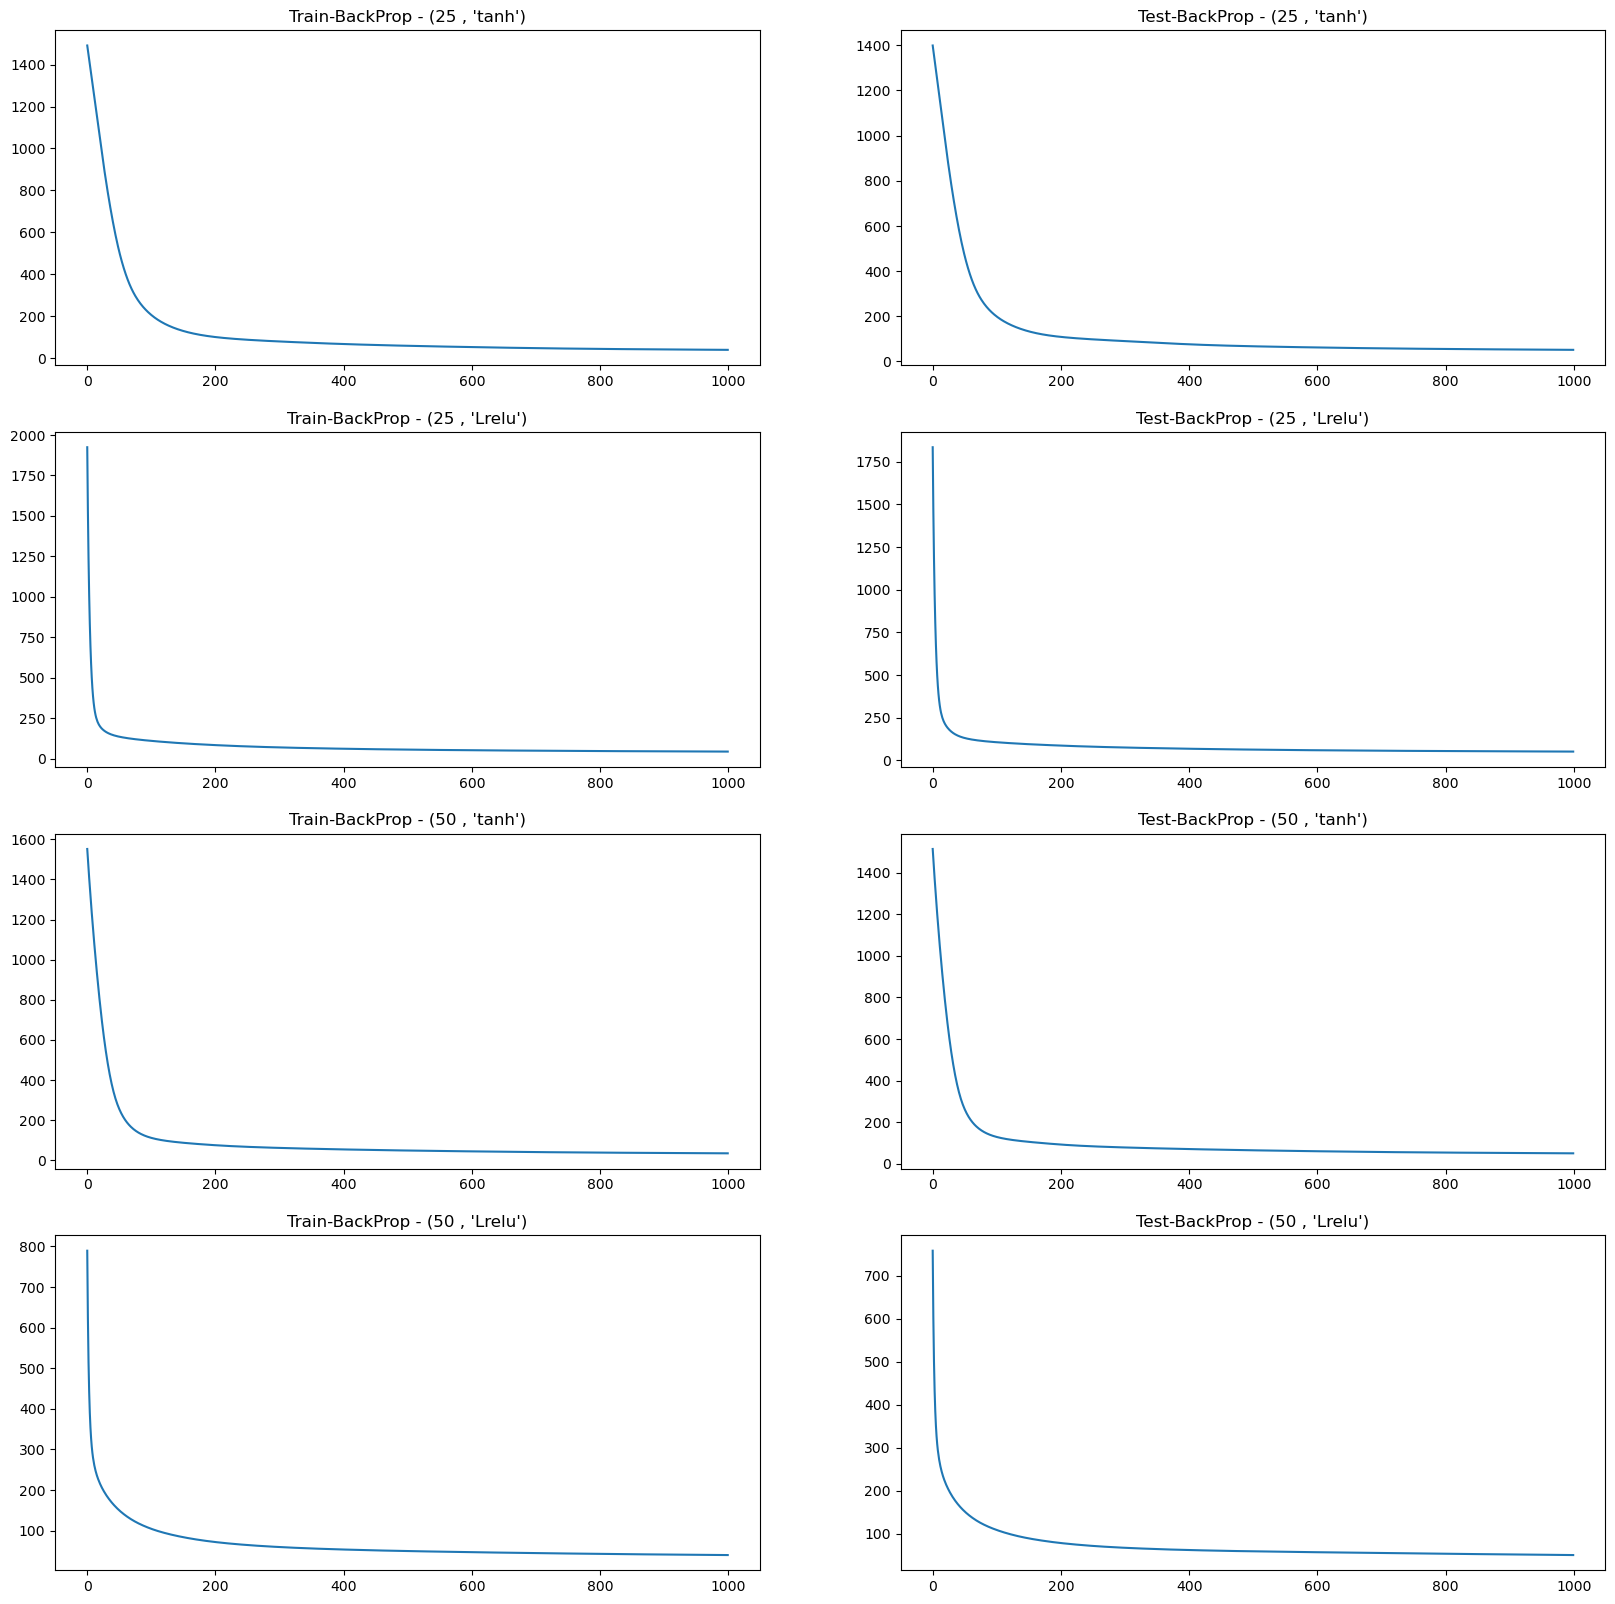

In [807]:
fig, axs = plt.subplots(4,2,figsize = (20,20))
training_losses = []
time_taken = []
converge_epochs = []
for idx, units in enumerate([25,50]):
    back_nn = NN_back(hidden_units=units,activation=1)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx,0].plot(range(1000),loss_list)
    axs[2*idx,0].set_title(f"Train-BackProp - ({units} , 'tanh')")
    axs[2*idx,1].plot(range(1000),test_loss_list)
    axs[2*idx,1].set_title(f"Test-BackProp - ({units} , 'tanh')")
    print(f"Traing Loss in BackProp - ({units} , 'tanh') ===> {training_loss}")
    print(f"Test Loss in BackProp - ({units} , 'tanh') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)
    
    back_nn = NN_back(hidden_units=units,activation=2)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx+1,0].plot(range(1000),loss_list)
    axs[2*idx+1,0].set_title(f"Train-BackProp - ({units} , 'Lrelu')")
    axs[2*idx+1,1].plot(range(1000),test_loss_list)
    axs[2*idx+1,1].set_title(f"Test-BackProp - ({units} , 'Lrelu')")
    print(f"Traing Loss in BackProp - ({units} , 'Lrelu') ===> {training_loss}")
    print(f"Test Loss in BackProp - ({units} , 'Lrelu') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)

### Loss, Time and Convergence Analysis 

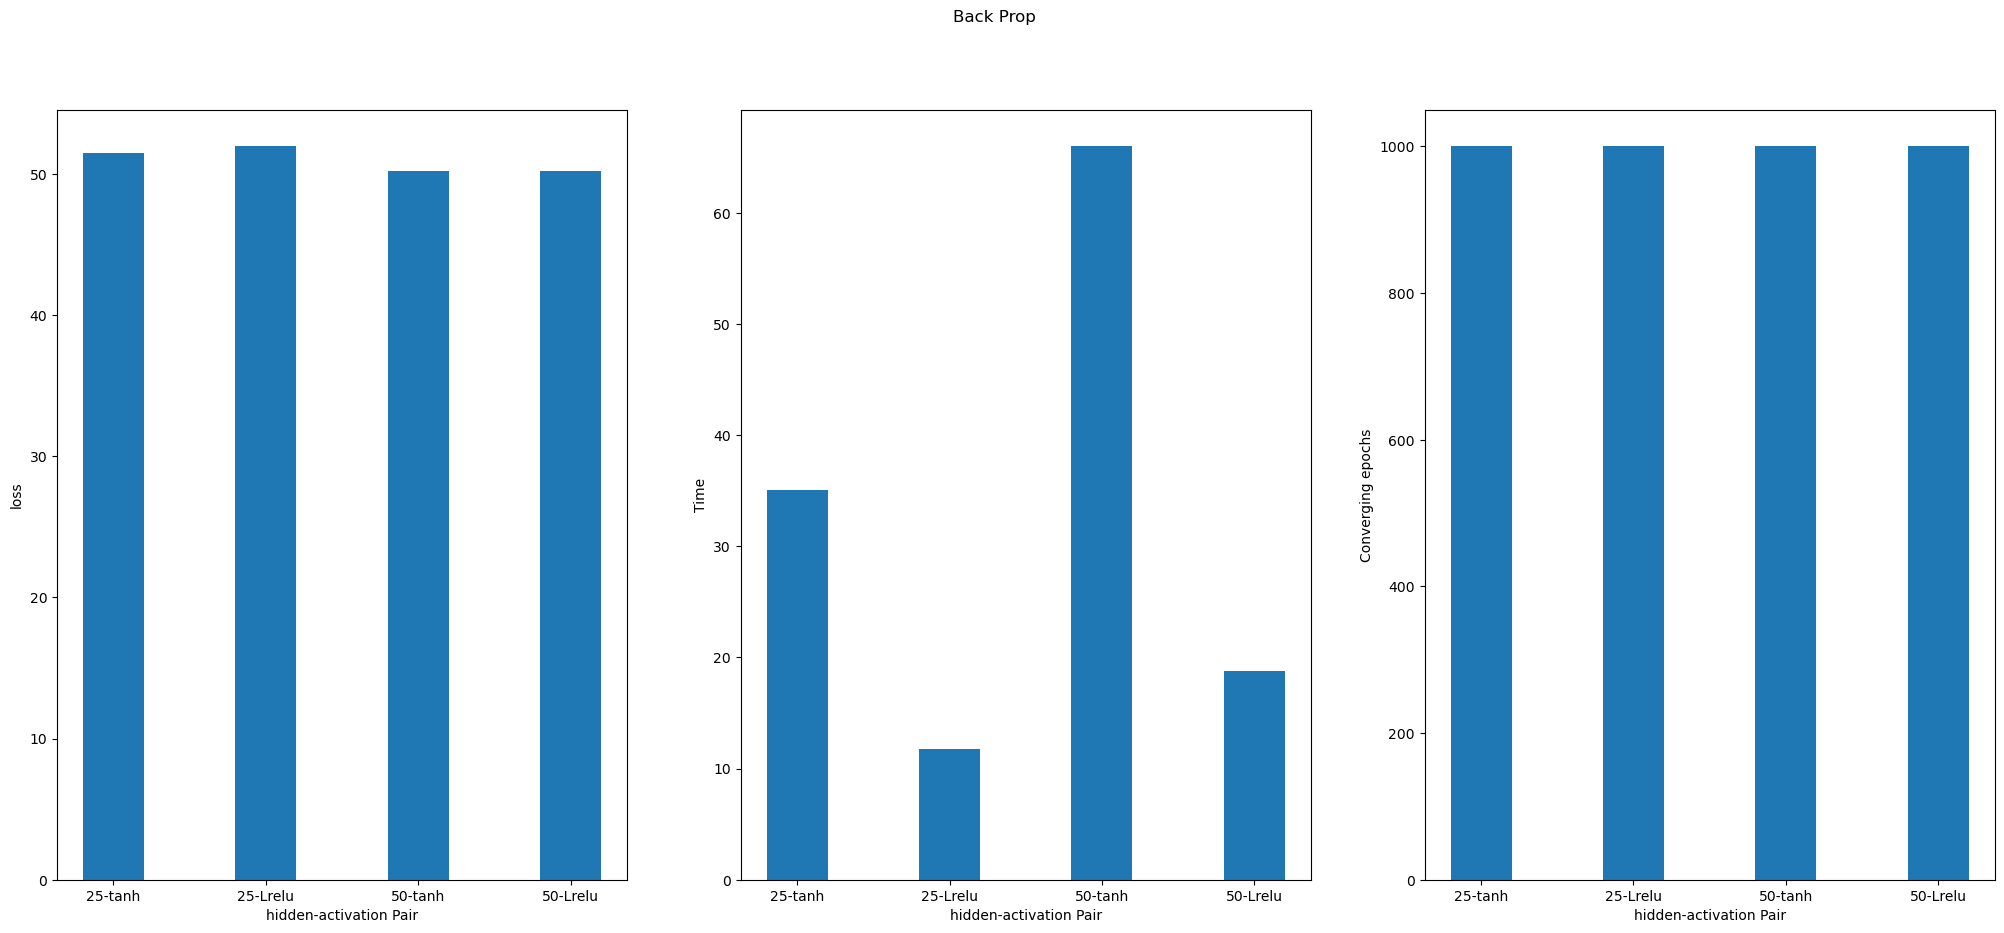

In [808]:
X = ['25-tanh','25-Lrelu','50-tanh','50-Lrelu']
fig, ax = plt.subplots(1,3,figsize = (25,10))
ax[0].bar(X,training_losses,0.4)
ax[0].set_xlabel('hidden-activation Pair')
ax[1].bar(X,time_taken,0.4)
ax[1].set_xlabel('hidden-activation Pair')
ax[2].bar(X,converge_epochs,0.4)
ax[2].set_xlabel('hidden-activation Pair')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('Time')
ax[2].set_ylabel('Converging epochs')
fig.suptitle('Back Prop')
plt.show()


#### Loss:
The Test loss for the Hidden layer with 50 nodes is coming lower than that of 25 nodes since with increased no. of nodes more information from the inputs can be processed, hence better prediction and lower loss. Then tanh function for the inputs perform similar to that of the Lealy relu, however Lrelu performs better in Average
#### Time taken:
Time taken by models with tanh is more than that with Lrelu since Computing tanh activation and its gradient is computationally heavier. With the same activation function, Hidden layer with less no. of units runs faster
#### Convergence
No pair converges fast enough keeping convergence factor to be 1e-3, however from the graph its clear than Lrelu converges faster than Tanh

## RProp Training and Testing

Traing Loss in RProp - (25 , 'tanh') ===> 28.881417255620608
Test Loss in RProp - (25 , 'tanh') ===> 62.11185752265918
Traing Loss in RProp - (25 , 'Lrelu') ===> 29.19806265297366
Test Loss in RProp - (25 , 'Lrelu') ===> 53.74596536982853
Traing Loss in RProp - (50 , 'tanh') ===> 14.653250692947827
Test Loss in RProp - (50 , 'tanh') ===> 44.06172160523441
Traing Loss in RProp - (50 , 'Lrelu') ===> 19.883180135820144
Test Loss in RProp - (50 , 'Lrelu') ===> 30.85744295192262


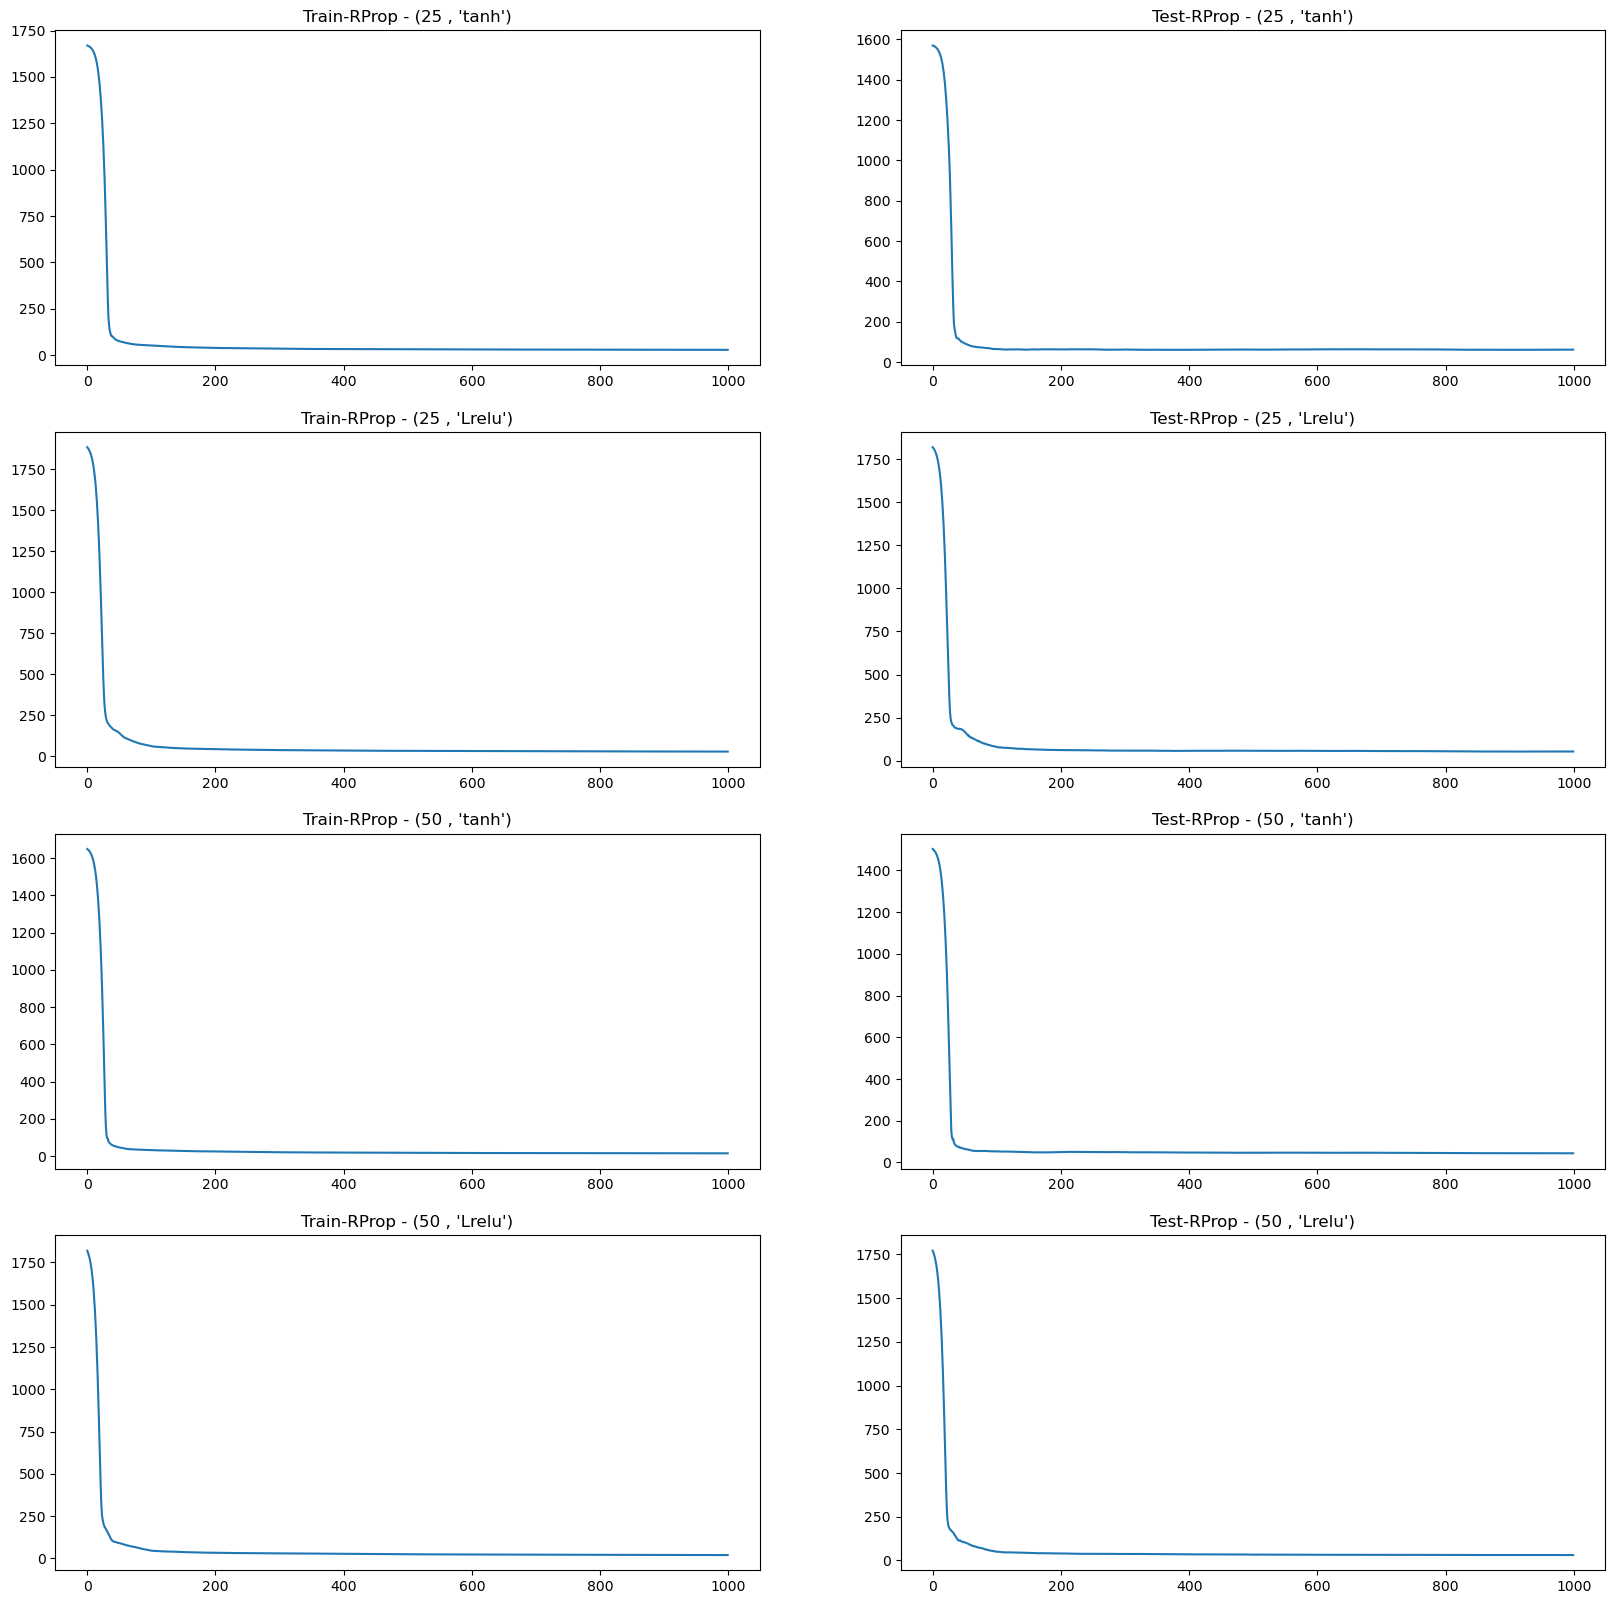

In [816]:
fig, axs = plt.subplots(4,2,figsize = (20,20))
training_losses = []
time_taken = []
converge_epochs = []
for idx, units in enumerate([25,50]):
    back_nn = NN_r(hidden_units=units,activation=1)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx,0].plot(range(1000),loss_list)
    axs[2*idx,0].set_title(f"Train-RProp - ({units} , 'tanh')")
    axs[2*idx,1].plot(range(1000),test_loss_list)
    axs[2*idx,1].set_title(f"Test-RProp - ({units} , 'tanh')")
    print(f"Traing Loss in RProp - ({units} , 'tanh') ===> {training_loss}")
    print(f"Test Loss in RProp - ({units} , 'tanh') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)
    
    back_nn = NN_r(hidden_units=units,activation=2)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx+1,0].plot(range(1000),loss_list)
    axs[2*idx+1,0].set_title(f"Train-RProp - ({units} , 'Lrelu')")
    axs[2*idx+1,1].plot(range(1000),test_loss_list)
    axs[2*idx+1,1].set_title(f"Test-RProp - ({units} , 'Lrelu')")
    print(f"Traing Loss in RProp - ({units} , 'Lrelu') ===> {training_loss}")
    print(f"Test Loss in RProp - ({units} , 'Lrelu') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)

### Loss, Time and Convergence Analysis

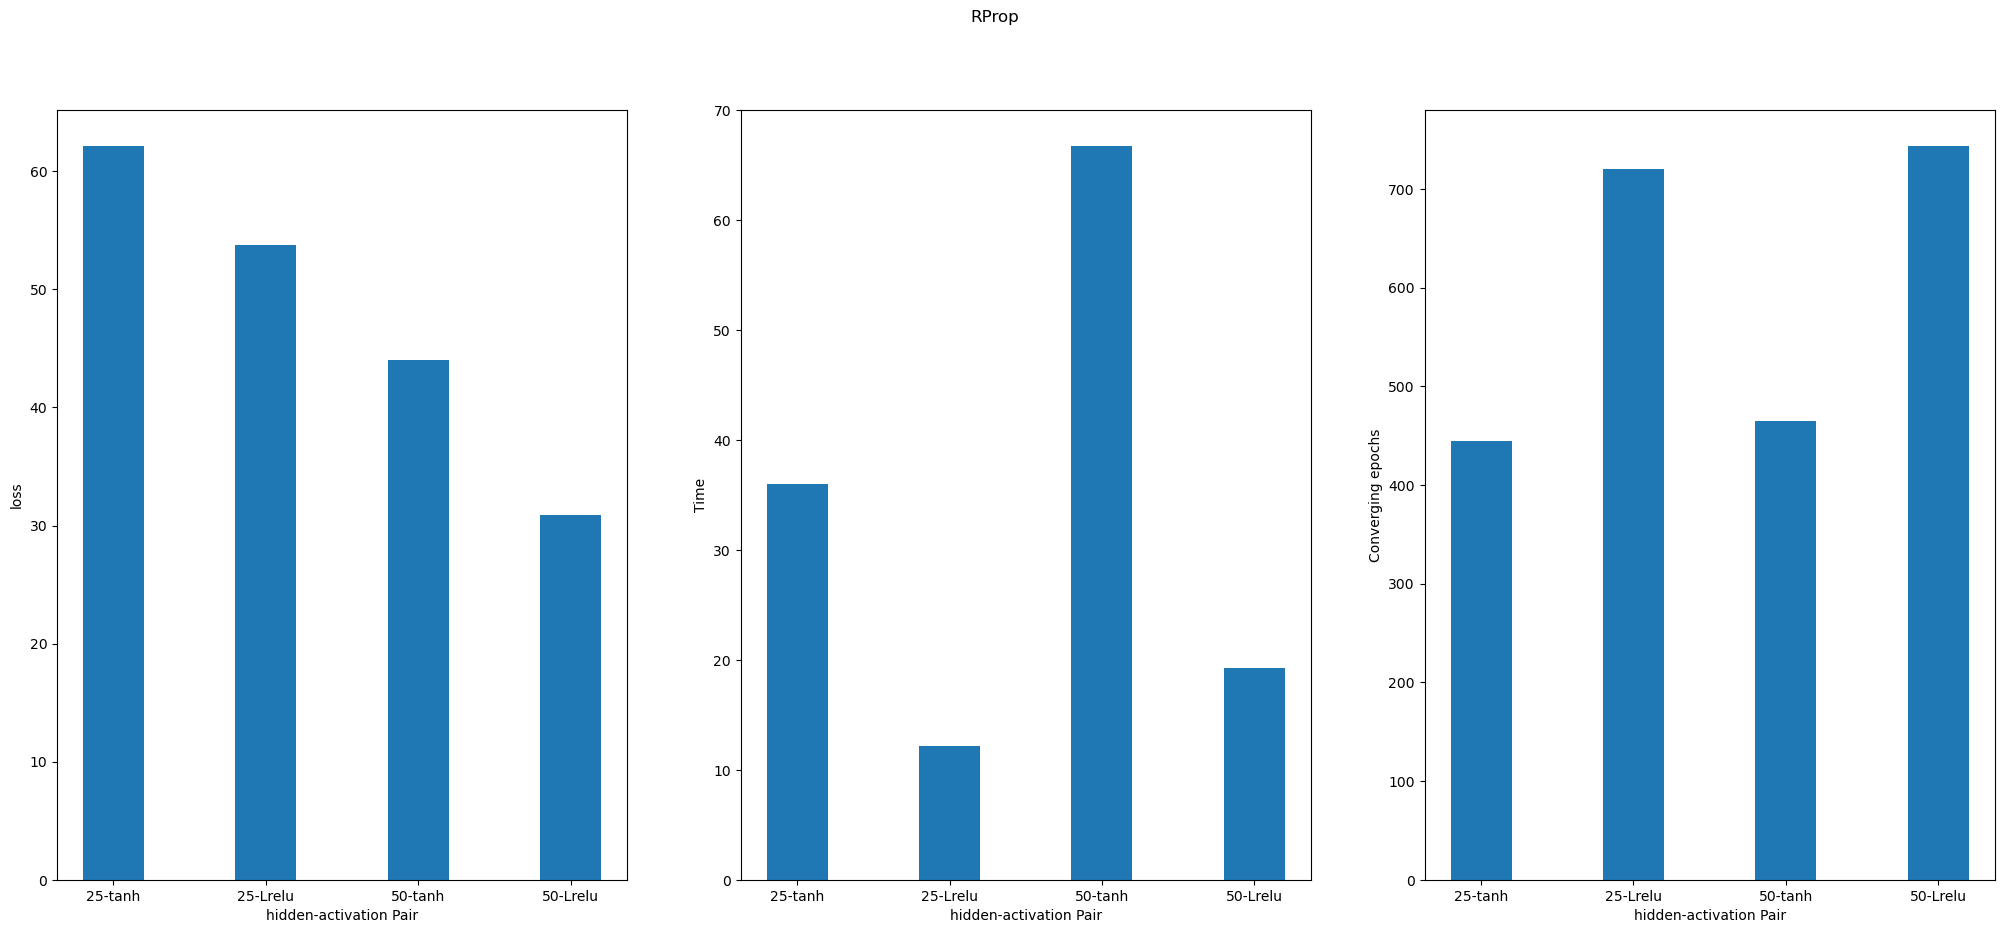

In [817]:
X = ['25-tanh','25-Lrelu','50-tanh','50-Lrelu']
fig, ax = plt.subplots(1,3,figsize = (25,10))
ax[0].bar(X,training_losses,0.4)
ax[0].set_xlabel('hidden-activation Pair')
ax[1].bar(X,time_taken,0.4)
ax[1].set_xlabel('hidden-activation Pair')
ax[2].bar(X,converge_epochs,0.4)
ax[2].set_xlabel('hidden-activation Pair')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('Time')
ax[2].set_ylabel('Converging epochs')
fig.suptitle('RProp')
plt.show()

#### Loss:
The Test loss for models with Lrelu activation perform better than those with tanh. With the same activation function, The model with more hidden units perform better 
#### Time taken:
Time taken by models with tanh is more than that with Lrelu since Computing tanh activation and its gradient is computationally heavier. With the same activation function, Hidden layer with less no. of units runs faster
#### Convergence
Keeping convergence factor to be 1e-3, models with Tanh activation perform better than those with tanh. With the same activation function, The model with less hidden units show faster convergence

## QuickProp Training and Testing

Traing Loss in QuickProp - (25 , 'tanh') ===> 53.20684465799211
Test Loss in QuickProp - (25 , 'tanh') ===> 62.035533542903956
Traing Loss in QuickProp - (25 , 'Lrelu') ===> 26.69987770366449
Test Loss in QuickProp - (25 , 'Lrelu') ===> 36.46121860313231
Traing Loss in QuickProp - (50 , 'tanh') ===> 35.6939309085465
Test Loss in QuickProp - (50 , 'tanh') ===> 50.0632084522509
Traing Loss in QuickProp - (50 , 'Lrelu') ===> 19.252178160240234
Test Loss in QuickProp - (50 , 'Lrelu') ===> 33.85620487244931


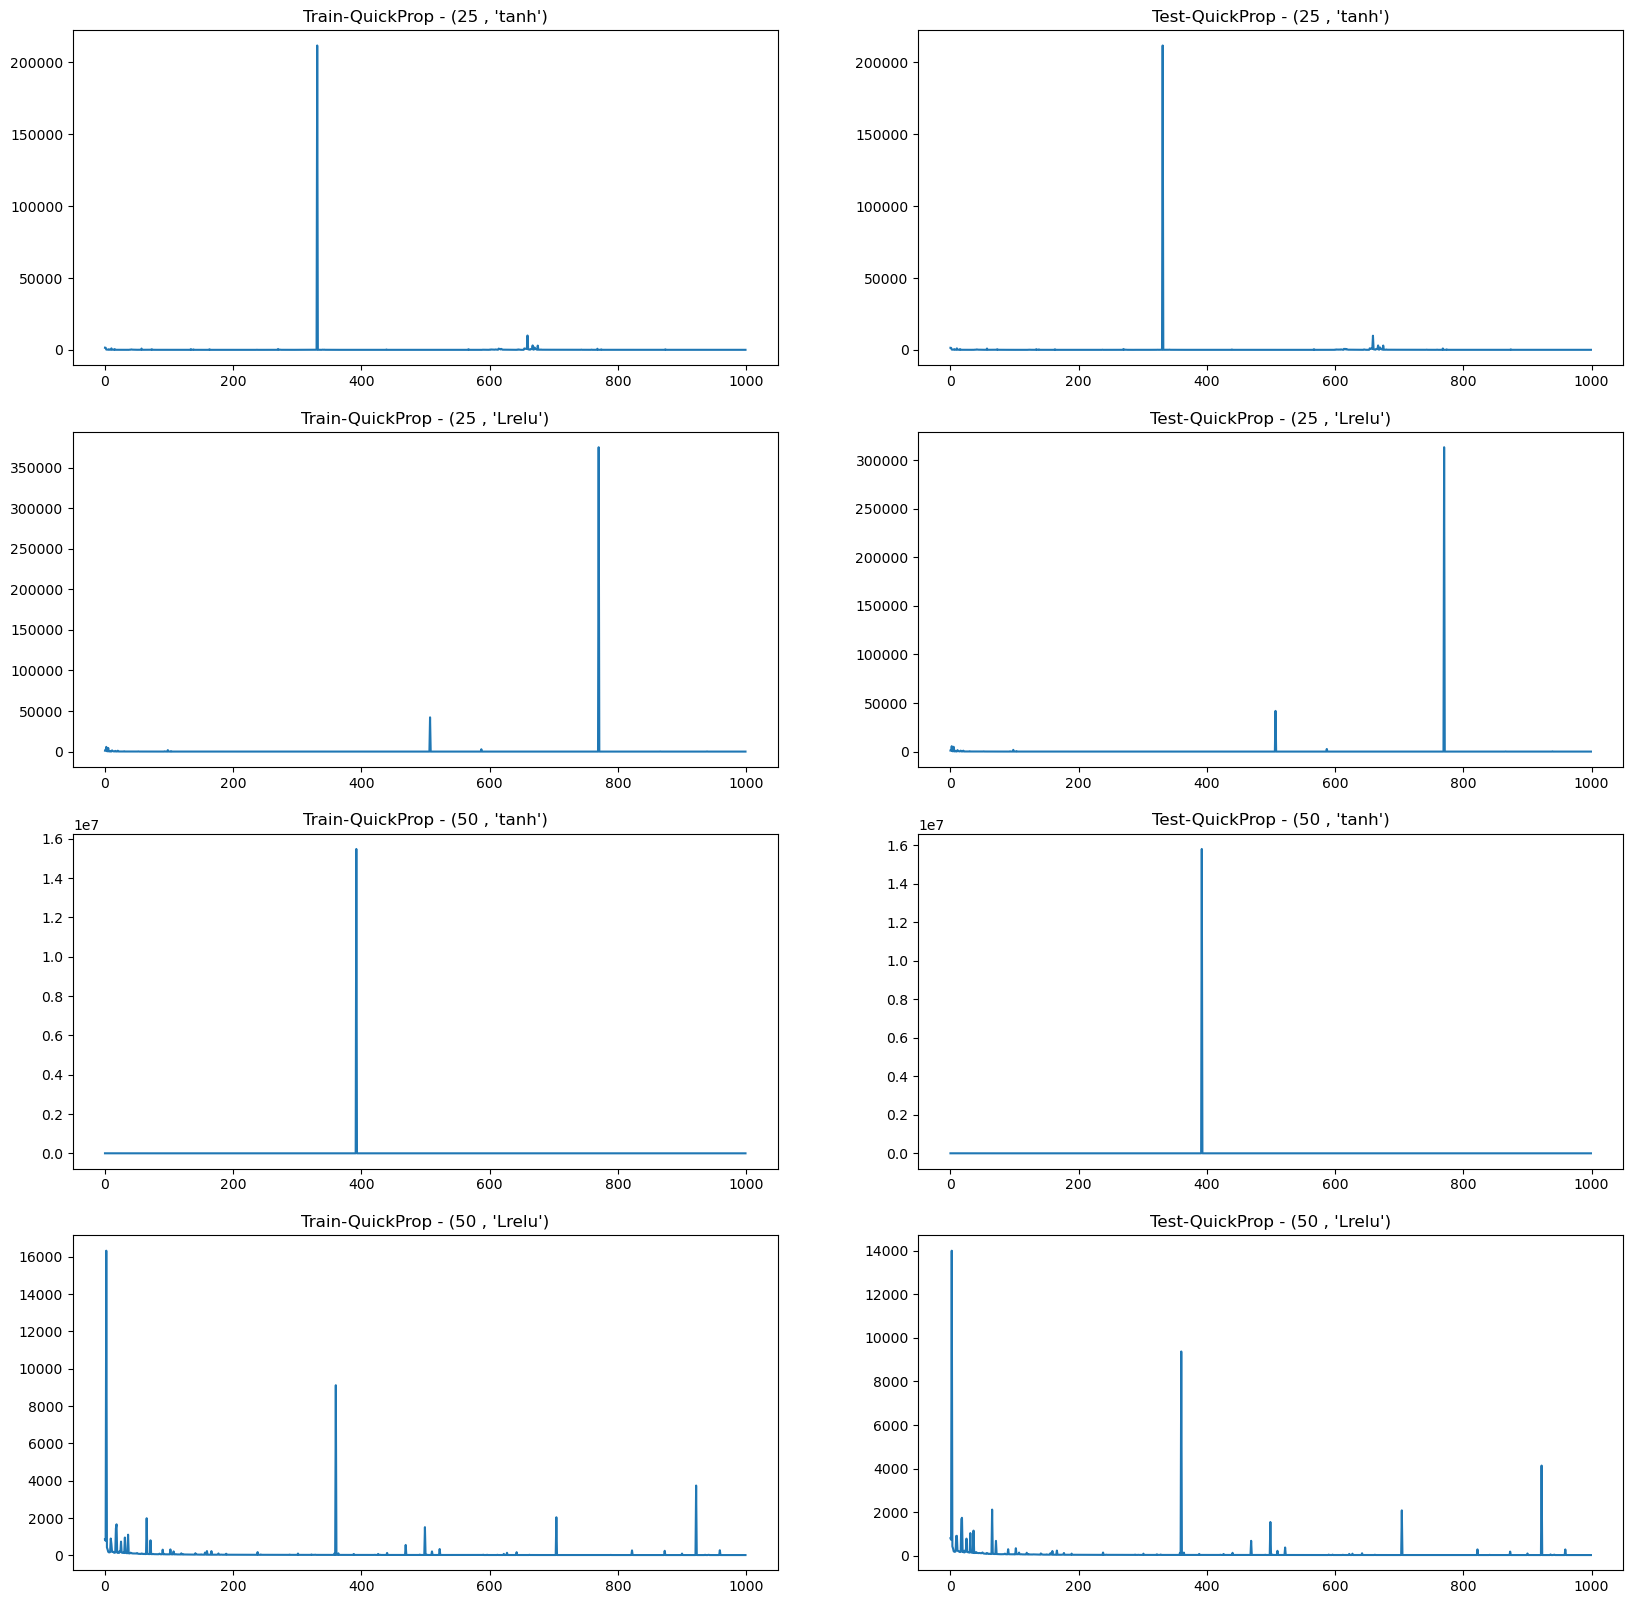

In [822]:
fig, axs = plt.subplots(4,2,figsize = (20,20))
training_losses = []
time_taken = []
converge_epochs = []
for idx, units in enumerate([25,50]):
    back_nn = NN_quick(hidden_units=units,activation=1)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx,0].plot(range(1000),loss_list)
    axs[2*idx,0].set_title(f"Train-QuickProp - ({units} , 'tanh')")
    axs[2*idx,1].plot(range(1000),test_loss_list)
    axs[2*idx,1].set_title(f"Test-QuickProp - ({units} , 'tanh')")
    print(f"Traing Loss in QuickProp - ({units} , 'tanh') ===> {training_loss}")
    print(f"Test Loss in QuickProp - ({units} , 'tanh') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)
    
    back_nn = NN_quick(hidden_units=units,activation=2)
    start = time.time()
    loss_list, training_loss, test_loss_list, convergent_epoch = back_nn.fit_batch(x_train[:],np.array(y_train)[:],x_test[:],np.array(y_test)[:])
    end = time.time()
    test_loss = back_nn.predict(x_test,np.array(y_test))
    axs[2*idx+1,0].plot(range(1000),loss_list)
    axs[2*idx+1,0].set_title(f"Train-QuickProp - ({units} , 'Lrelu')")
    axs[2*idx+1,1].plot(range(1000),test_loss_list)
    axs[2*idx+1,1].set_title(f"Test-QuickProp - ({units} , 'Lrelu')")
    print(f"Traing Loss in QuickProp - ({units} , 'Lrelu') ===> {training_loss}")
    print(f"Test Loss in QuickProp - ({units} , 'Lrelu') ===> {test_loss}")
    training_losses.append(test_loss)
    time_taken.append(end-start)
    converge_epochs.append(convergent_epoch)

### Loss, Time and Convergence Analysis

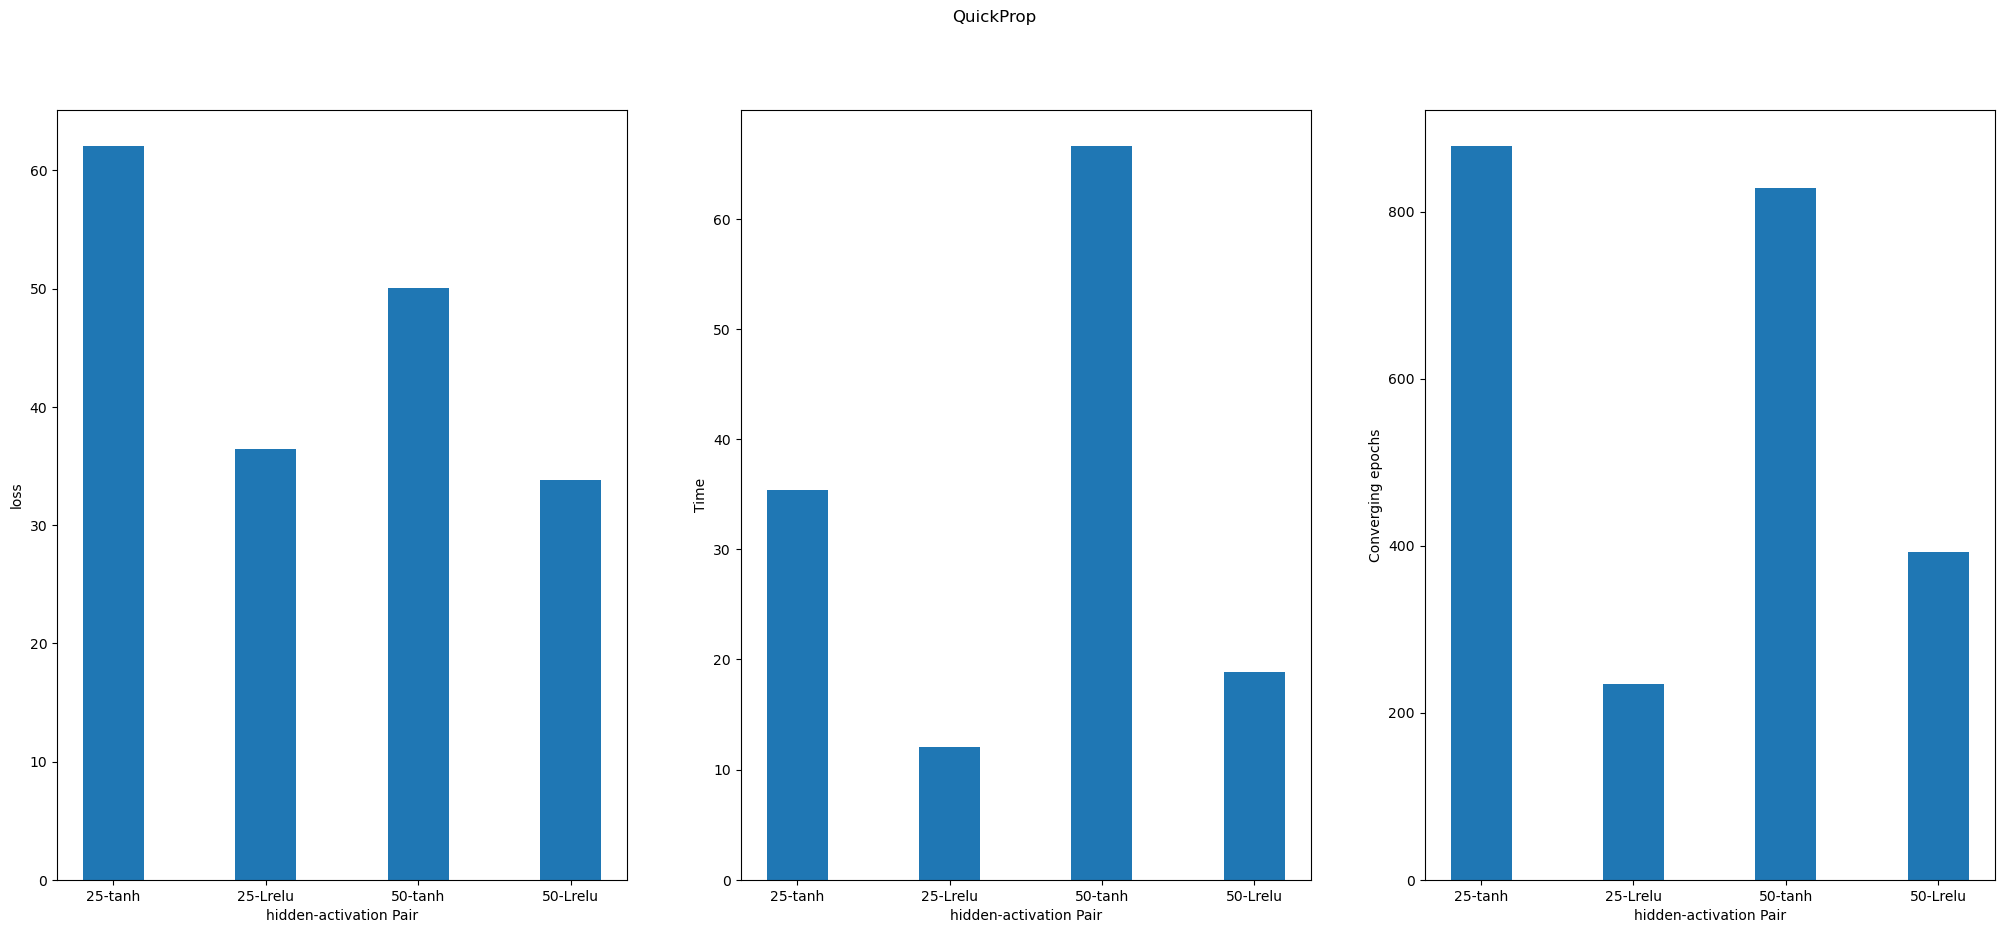

In [823]:
X = ['25-tanh','25-Lrelu','50-tanh','50-Lrelu']
fig, ax = plt.subplots(1,3,figsize = (25,10))
ax[0].bar(X,training_losses,0.4)
ax[0].set_xlabel('hidden-activation Pair')
ax[1].bar(X,time_taken,0.4)
ax[1].set_xlabel('hidden-activation Pair')
ax[2].bar(X,converge_epochs,0.4)
ax[2].set_xlabel('hidden-activation Pair')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('Time')
ax[2].set_ylabel('Converging epochs')
fig.suptitle('QuickProp')
plt.show()

#### Loss:
The Test loss for models with Lrelu activation perform much better than those with tanh. With the same activation function, The model with more hidden units perform better 
#### Time taken:
Time taken by models with tanh is more than that with Lrelu since Computing tanh activation and its gradient is computationally heavier. With the same activation function, Hidden layer with less no. of units runs faster
#### Convergence
Keeping convergence factor to be 1e-3, models with Lrelu activation perform better than those with tanh. With the same activation function, The model with less hidden units show faster convergence